In [1]:
import multiprocessing
ncores = multiprocessing.cpu_count()
ncores

16

!pip install pdal

PDAL all of a sudden wants nupmy <= 1.20.0, you may need to conda update it

In [2]:
import numpy as np
np.version.version

'1.20.1'

In [3]:
from osgeo import osr
import pdal
from string import Template
import numpy as np
import pandas as pd
import h5py
import json
import requests
import os
import subprocess

Now make the bbox, transform it to EPSG:3857, and divide it into tiles for use with the ept reader.  We will also make a GEOjson of the bbox in EPSG:4326 for use later.

In [4]:
# bbox of Hollywood
xmin_ = -118.368793
ymin_ = 34.076306
xmax_ = -118.3284614 
ymax_ = 34.111215


# make a geojson, see below   
gjson = {'coordinates' : [[[xmin_, ymin_], [xmin_, ymax_], [xmax_, ymax_], [xmax_, ymin_]]],
         'type' : 'Polygon'}
with open('hollywood_box.json', 'w') as of:
    json.dump(gjson, of)


# define transform from EPSG:4326 to EPSG:3857
old_crs = osr.SpatialReference() 
old_crs.ImportFromEPSG(4326) 
new_crs = osr.SpatialReference() 
new_crs.ImportFromEPSG(3857)
transform = osr.CoordinateTransformation(old_crs,new_crs)

# define transform from EPSG:4326 to EPSG:26911
new_crs_26911 = osr.SpatialReference() 
new_crs_26911.ImportFromEPSG(26911)
transform_26911 = osr.CoordinateTransformation(old_crs,new_crs_26911)

# transform bbox points for the ept reader
xmin, ymin, zmin = transform.TransformPoint(ymin_, xmin_)
xmax, ymax, zmax = transform.TransformPoint(ymax_, xmax_)

# transform bbox points for clipping the raster
xmin_26911, ymin_26911, zmin_26911 = transform_26911.TransformPoint(ymin_, xmin_)
xmax_26911, ymax_26911, zmax_26911 = transform_26911.TransformPoint(ymax_, xmax_)


#make tiles for ept reader (EPSG:3857)
n = 10
dx = abs(xmin - xmax) / n
dy = abs(ymin - ymax) / n

In the above cell we created a GEOjson ```holywood_box.json```.  I downloaded it and compared it to the tiles shapefile for the NAIP data in order to find the url for the tile we need. Now we can download the tile that we need. 

In [23]:
# paths, urls 
tmp = '/home/jovyan/tmp'
url = 'https://coast.noaa.gov/htdata/raster5/imagery/CA_NAIP_2018_9159/m_3411862_nw_11_060_20180723.tif'
fname = os.path.join(tmp, 'm_3411862_nw_11_060_20180723.tif')

# make sure tmp exists
os.makedirs(tmp, exist_ok=True)

# download the tif
response = requests.get(url)
with open(fname, 'wb') as sink:
            sink.write(response.content)


Next we clip the raster to the bbox of Hollywood using EPSG:26911 coordinates.

In [10]:
# make outfile path
clipped_fname = os.path.join(tmp, 'hollywood.tif')

# make the args list
cmd = f'gdalwarp -te {xmin_26911} {ymin_26911} {xmax_26911} {ymax_26911} {fname} {clipped_fname}'

# call the command
result = subprocess.run(cmd, shell=True, capture_output=True)

NameError: name 'tmp' is not defined

I downloaded ```hollywood.tif``` and viewd it in QGIS to make sure it is correct. It is. Now we will calculate NDVI from ```hollywood.tif```.  First lets look at the band definitions to make sure we know what we are working with.

In [5]:
import pprint
cmd = 'gdalinfo /home/jovyan/tmp/hollywood.tif | grep ColorInterp'
result = subprocess.run(cmd, shell=True, capture_output=True)
pprint.pprint(str(result.stdout).split('\\n'))

["b'Band 1 Block=6287x1 Type=Byte, ColorInterp=Red",
 'Band 2 Block=6287x1 Type=Byte, ColorInterp=Green',
 'Band 3 Block=6287x1 Type=Byte, ColorInterp=Blue',
 'Band 4 Block=6287x1 Type=Byte, ColorInterp=Undefined',
 "'"]


Import some more crap that we will need.

In [8]:
from rasterio.windows import Window
import rasterio as rio
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import xarray as xr
import matplotlib.pyplot as plt

Open the raster with rasterio.  Make the data into an xarray because they are a little easier to work with imho.  Also get rif of ```inf``` values.  This should not be necessary, but I find that the later steps tend to fail without doing so.

In [13]:
with rio.open(clipped_fname, 'r') as src:
    profile = src.profile
    data = src.read()
    
xdata = xr.DataArray(data)
xdata= xdata.where(data != np.inf)

In [35]:
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6287, 'height': 6370, 'count': 4, 'crs': CRS.from_epsg(26911), 'transform': Affine(0.5999539188936744, 0.0, 373703.5645468485,
       0.0, -0.599999882105235, 3775284.05104048), 'tiled': False, 'interleave': 'pixel'}

Calculate NDVI.

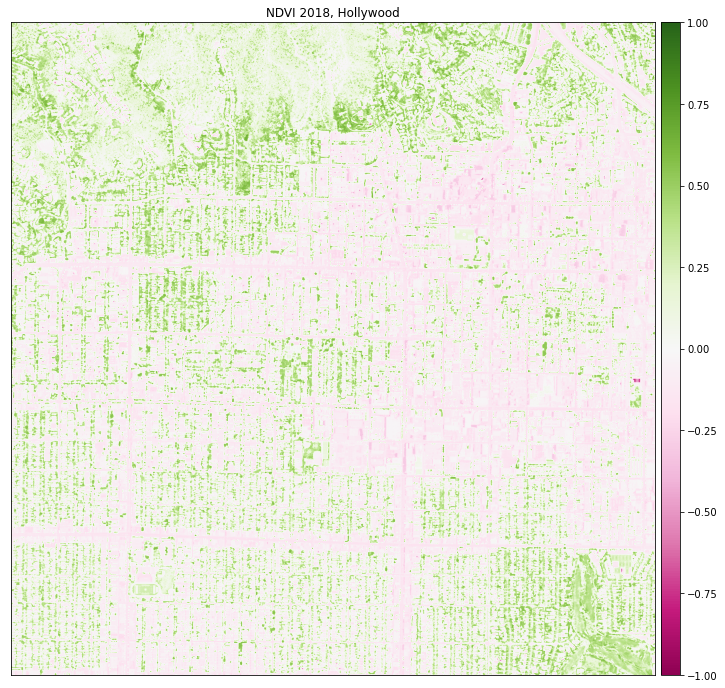

In [14]:
ndvi = es.normalized_diff(xdata[3], xdata[0])
ep.plot_bands(ndvi, cmap='PiYG', scale=False, vmin=-1, vmax=1, title='NDVI 2018, Hollywood');

Now look at the histogram of a subset.  

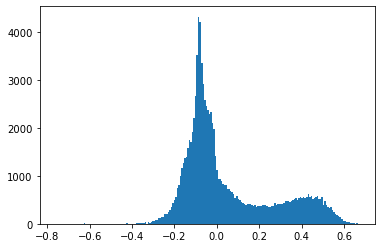

In [29]:
samp = np.random.choice(ndvi.data.flatten(), size=100000)
ax = plt.hist(samp, bins=200);

We will pich a threshod of 0.25 based on the hist above and make a mask.  Also check that the mask won

In [30]:
thresh = 0.25
mask = ndvi > thresh
rio.dtypes.can_cast_dtype(mask, 'uint8')

True

In the pipeline below:
>we read the ept  
>we filter outliers  
>we reproject to UTM 11  
>we classify ground points  
>we find haieght above ground  
>we select 35m as the limit on ```HeightAboveGround``` because it is a reasonable value and it is the 0.999 quantile on a tif made with no limit  
> we us ```filters.coloration``` to mask the points as vegetation

In [48]:
def make_pipe(bbox, chm_path, srs='EPSG:3857', threads=4, resolution=1):
    '''Creates, validates and then returns the pdal pipeline
    
    Arguments:
    bbox       -- Tuple - Bounding box in srs coordintes (default srs is EPSG:3857),
                  in the form: ([xmin, xmax], [ymin, ymax]).
    chm_path   -- String - Path where the CHM shall be saved. Must include .tif exstension.
    srs        -- String - EPSG identifier for srs  being used. Defaults to EPSG:3857
                  because that is what ept files tend to use.
    threads    -- Int - Number os threads to be used by the reader.ept. Defaults to 4.
    resolution -- Int or Float - resolution (m) used by writers.gdal
    '''
    
    t = Template('''
    {
        "pipeline": [
            {
            "bounds": "${scaled_bbox}",
            "filename": "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_CA_LosAngeles_2016_LAS_2018/ept.json",
            "type": "readers.ept",
            "tag": "readdata",
            "spatialreference": "${srs}",
            "threads": "${threads}"
            },
            {
            "type":"filters.outlier",
            "method":"radius",
            "radius":1.0,
            "min_k":4
            },
            {
            "type": "filters.reprojection",
            "in_srs":"${srs}",
            "out_srs": "EPSG:26911"
            },
            {
            "type":"filters.smrf",
            "scalar":1.2,
            "slope":0.2,
            "threshold":0.45,
            "window":16.0
            },
            {
            "type":"filters.hag_delaunay"
            },
            {
            "type":"filters.range",
            "limits":"HeightAboveGround[0:35]"
            },
            {
            "type":"filters.colorization",
            "dimensions":"Red:1:1.0, Blue, Green, NearIR",
            "roster":"Hollywood_naip.tiff"
            }
        ]
    }''')

    pipe = t.substitute(scaled_bbox=bbox, srs=srs, chm_path=chm_path, threads=threads)
    pipeline = pdal.Pipeline(pipe)
    if pipeline.validate():
        return(pipeline)
    else:
        raise Exception('Bad pipeline (sorry to be so ambigous)!')

In [6]:


x = xmin
xs = []
while x < xmax:
    xs.append([x, x + dx])
    x = x + dx
if x < xmax:
    xs.append([x, xmax])

y = ymin
ys = []
while y < ymax:
    ys.append([y, y + dy])
    y = y + dy
if y < ymax:
    ys.append([y, ymax])

    
bxs = []
for x in xs:
    for y in ys:
        bbox = (x, y)
        bxs.append(bbox)



In [7]:
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import os

In [8]:
@delayed
def tilez(i, bbox):
    chm_path = f'{Hollywood}/chm{i}.tif'
    pipeline = make_pipe(bbox, chm_path)
    try:
        count = pipeline.execute()
        # For point cloud in a numpy array
        S = pipeline.arrays[0]

        # WRITE TO h5 HERE (JUST WHATEVER IS IN S)
        return (S,i)
    except RuntimeError as e:
        print(f'This happened --{e}-- on the bbox {bbox}')
    except Exception as e:
        print(f'pipeline failed on this {bbox} due to \n{e}')
    
    

# make a variable for its path
# home = os.path.expanduser('~')
# tmp = f'{home}/tmp'
Hollywood = os.getcwd() + '/Hollywood' 
    
results = []
for i, bbox in enumerate(bxs):
    if i == 1:
        # Instead of appending to results, write to an h5 file.
        results.append(tilez(i, bbox))

with ProgressBar():
    computed_results = compute(*results)

[                                        ] | 0% Completed | 30.1s


KeyboardInterrupt: 

In [10]:
computed_results

((array([(8, 2, 0, 1.36361890e+08,  720, 1, 4968, 603, 1,  9., 0, 1, 0, 374078.75592134, 3772180.87000016, 65.09,  0.        ),
         (8, 2, 0, 1.36361890e+08,  784, 1, 4968, 603, 1,  9., 0, 1, 0, 374080.156674  , 3772180.85131716, 65.15,  0.        ),
         (8, 2, 0, 1.36361890e+08,  656, 1, 4968, 603, 1,  9., 0, 1, 0, 374080.62922737, 3772180.8532662 , 65.16,  0.        ),
         ...,
         (0, 2, 0, 1.39907357e+08, 1904, 1, 4683, 403, 1,  0., 0, 1, 0, 373817.61144278, 3771934.6940526 , 58.77,  0.        ),
         (8, 1, 0, 1.39907358e+08,  416, 3, 4688, 403, 1, -8., 0, 1, 0, 373794.47006942, 3772198.96649292, 88.48, 26.10429214),
         (8, 7, 0, 1.39907358e+08,  992, 2, 4683, 403, 1, -6., 0, 1, 0, 373766.29756291, 3772110.77585042, 85.68, 24.82      )],
        dtype=[('ClassFlags', 'u1'), ('Classification', 'u1'), ('EdgeOfFlightLine', 'u1'), ('GpsTime', '<f8'), ('Intensity', '<u2'), ('NumberOfReturns', 'u1'), ('OriginId', '<u4'), ('PointSourceId', '<u2'), ('ReturnNu

In [35]:
df = pd.DataFrame(computed_results[0][0])
df

,ClassFlags,Classification,EdgeOfFlightLine,GpsTime,Intensity,NumberOfReturns,OriginId,PointSourceId,ReturnNumber,ScanAngleRank,ScanChannel,ScanDirectionFlag,UserData,X,Y,Z,HeightAboveGround
0,8,2,0,1.363619e+08,720,1,4968,603,1,9.0,0,1,0,374078.755921,3.772181e+06,65.09,0.000000
1,8,2,0,1.363619e+08,784,1,4968,603,1,9.0,0,1,0,374080.156674,3.772181e+06,65.15,0.000000
2,8,2,0,1.363619e+08,656,1,4968,603,1,9.0,0,1,0,374080.629227,3.772181e+06,65.16,0.000000
3,8,2,0,1.363619e+08,784,1,4968,603,1,9.0,0,1,0,374081.574224,3.772181e+06,65.17,0.000000
4,8,2,0,1.363619e+08,832,1,4968,603,1,9.0,0,1,0,374083.961526,3.772181e+06,65.13,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363178,8,2,0,1.399074e+08,1856,1,4683,403,1,-5.0,0,0,0,373821.191338,3.772099e+06,61.09,0.000000
1363179,8,2,0,1.399074e+08,2096,1,4683,403,1,-3.0,0,0,0,373818.971872,3.772017e+06,59.69,0.000000
1363180,0,2,0,1.399074e+08,1904,1,4683,403,1,0.0,0,1,0,373817.611443,3.771935e+06,58.77,0.000000
1363181,8,1,0,1.399074e+08,416,3,4688,403,1,-8.0,0,1,0,373794.470069,3.772199e+06,88.48,26.104292


In [ ]:
# X,Y,Z, HeightAboveGround,ScanAngleRank,Intensity,NumberOrReturns,ReturnNumber,Classification,EdgeOfFilghtLine,ClassFlags

In [34]:
data = computed_results[0][0][['ClassFlags',
                         'EdgeOfFlightLine',
                         'Intensity',
                         'NumberOfReturns',
                         'ReturnNumber',
                         'ScanAngleRank',
                         'X',
                         'Y',
                         'Z',
                         'HeightAboveGround',
                         'Classification']]
pd.DataFrame(data)

,ClassFlags,EdgeOfFlightLine,Intensity,NumberOfReturns,ReturnNumber,ScanAngleRank,X,Y,Z,HeightAboveGround,Classification
0,8,0,720,1,1,9.0,374078.755921,3.772181e+06,65.09,0.000000,2
1,8,0,784,1,1,9.0,374080.156674,3.772181e+06,65.15,0.000000,2
2,8,0,656,1,1,9.0,374080.629227,3.772181e+06,65.16,0.000000,2
3,8,0,784,1,1,9.0,374081.574224,3.772181e+06,65.17,0.000000,2
4,8,0,832,1,1,9.0,374083.961526,3.772181e+06,65.13,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...
1363178,8,0,1856,1,1,-5.0,373821.191338,3.772099e+06,61.09,0.000000,2
1363179,8,0,2096,1,1,-3.0,373818.971872,3.772017e+06,59.69,0.000000,2
1363180,0,0,1904,1,1,0.0,373817.611443,3.771935e+06,58.77,0.000000,2
1363181,8,0,416,3,1,-8.0,373794.470069,3.772199e+06,88.48,26.104292,1


In [55]:
hf = h5py.File('data.h5', 'w')

In [56]:
hf.create_dataset('dataset_2', data=computed_results[0][0])

<HDF5 dataset "dataset_2": shape (1363183,), type "|V60">

In [57]:
hf.close()

In [58]:
hf = h5py.File('data.h5', 'r')

In [59]:
hf.keys()

<KeysViewHDF5 ['dataset_2']>

In [60]:
np.array(hf.get('dataset_2'))

array([(8, 2, 0, 1.36361890e+08,  720, 1, 4968, 603, 1,  9., 0, 1, 0, 374078.75592134, 3772180.87000016, 65.09,  0.        ),
       (8, 2, 0, 1.36361890e+08,  784, 1, 4968, 603, 1,  9., 0, 1, 0, 374080.156674  , 3772180.85131716, 65.15,  0.        ),
       (8, 2, 0, 1.36361890e+08,  656, 1, 4968, 603, 1,  9., 0, 1, 0, 374080.62922737, 3772180.8532662 , 65.16,  0.        ),
       ...,
       (0, 2, 0, 1.39907357e+08, 1904, 1, 4683, 403, 1,  0., 0, 1, 0, 373817.61144278, 3771934.6940526 , 58.77,  0.        ),
       (8, 1, 0, 1.39907358e+08,  416, 3, 4688, 403, 1, -8., 0, 1, 0, 373794.47006942, 3772198.96649292, 88.48, 26.10429214),
       (8, 7, 0, 1.39907358e+08,  992, 2, 4683, 403, 1, -6., 0, 1, 0, 373766.29756291, 3772110.77585042, 85.68, 24.82      )],
      dtype=[('ClassFlags', 'u1'), ('Classification', 'u1'), ('EdgeOfFlightLine', 'u1'), ('GpsTime', '<f8'), ('Intensity', '<u2'), ('NumberOfReturns', 'u1'), ('OriginId', '<u4'), ('PointSourceId', '<u2'), ('ReturnNumber', 'u1'), ('

In [61]:
hf.close()

In [36]:
df.memory_usage().sum()

81791108

#### TESTING IT OUT---------

In [8]:
@delayed
def tilez(i, bbox):
    chm_path = f'{Hollywood}/chm{i}.tif'
    pipeline = make_pipe(bbox, chm_path)
    try:
        count = pipeline.execute()
        # For point cloud in a numpy array
        S = pipeline.arrays[0]
#         PC_data = S[0][0][['ClassFlags',
#                          'EdgeOfFlightLine',
#                          'Intensity',
#                          'NumberOfReturns',
#                          'ReturnNumber',
#                          'ScanAngleRank',
#                          'X',
#                          'Y',
#                          'Z',
#                          'HeightAboveGround',
#                          'Classification']]
        #hf.create_dataset('HollywoodPC_'+str(i), data=PC_data)
        #print(PC_data)
        # WRITE TO h5 HERE (JUST WHATEVER IS IN S)
        return (S,i)
    except RuntimeError as e:
        print(f'This happened --{e}-- on the bbox {bbox}')
    except Exception as e:
        print(f'pipeline failed on this {bbox} due to \n{e}')
    
    

# make a variable for its path
# home = os.path.expanduser('~')
# tmp = f'{home}/tmp'
Hollywood = os.getcwd() + '/Hollywood' 
hf = h5py.File('Hollywood_PC_Data2.h5', 'w')    
results = []
for i, bbox in enumerate(bxs):
    # Instead of appending to results, write to an h5 file.

    print(i)
    #results.append(tilez(i, bbox))
    try:
        cr = compute(tilez(i,bbox))
        hf.create_dataset('HollywoodPC_'+str(i), data=cr[0][0][['ClassFlags',
                         'EdgeOfFlightLine',
                         'Intensity',
                         'NumberOfReturns',
                         'ReturnNumber',
                         'ScanAngleRank',
                         'X',
                         'Y',
                         'Z',
                         'HeightAboveGround',
                         'Classification']])
    except:
        print("Error: ", i)

# with ProgressBar():
#     computed_results = compute(*results)
#     hf.create_dataset('HollywoodPC_'+str(i), data=computed_results[0][0][['ClassFlags',
#                          'EdgeOfFlightLine',
#                          'Intensity',
#                          'NumberOfReturns',
#                          'ReturnNumber',
#                          'ScanAngleRank',
#                          'X',
#                          'Y',
#                          'Z',
#                          'HeightAboveGround',
#                          'Classification']])

    
hf.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
This happened --readers.ept: Error reading tile: Could not read from s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_CA_LosAngeles_2016_LAS_2018/ept-data/11-952-1071-1014.laz-- on the bbox ([-13175406.85462194, -13174957.885304451], [4041868.2325416678, 4042337.4937270614])


TypeError: 'NoneType' object is not subscriptable

In [ ]:
hf = h5py.File('Hollywood_PC_Data.h5', 'r')

In [ ]:
hf.keys()

In [13]:
np.array(hf.get('HollywoodPC_99'))

array([(8, 0, 1072, 1, 1,  6., 373984.05390802, 3771845.38685333, 59.  ,  0.  , 2),
       (8, 0, 1008, 1, 1,  6., 373981.72487298, 3771845.42618967, 59.05,  0.  , 2),
       (8, 0,  768, 1, 1,  6., 373977.10006821, 3771845.5126722 , 59.01,  0.  , 2),
       ...,
       (8, 0, 2000, 1, 1,  7., 373751.9672257 , 3771706.57419342, 56.73,  0.  , 2),
       (8, 0, 1232, 2, 1, 13., 373753.03537744, 3771479.14150255, 81.3 , 26.09, 1),
       (8, 0,  448, 1, 1, 13., 373749.2634014 , 3771498.36236186, 55.49,  0.  , 2)],
      dtype={'names':['ClassFlags','EdgeOfFlightLine','Intensity','NumberOfReturns','ReturnNumber','ScanAngleRank','X','Y','Z','HeightAboveGround','Classification'], 'formats':['u1','u1','<u2','u1','u1','<f4','<f8','<f8','<f8','<f8','u1'], 'offsets':[0,2,11,13,20,21,28,36,44,52,1], 'itemsize':60})

In [19]:
hf.close()

In [15]:
@delayed
def tilez(i, bbox):
    chm_path = f'{Hollywood}/chm{i}.tif'
    pipeline = make_pipe(bbox, chm_path)
    try:
        count = pipeline.execute()
        # For point cloud in a numpy array
        S = pipeline.arrays[0]
        metadata = pipeline.metadata
        log = pipeline.log
        return (S,i)
    except RuntimeError as e:
        print(f'This happened --{e}-- on the bbox {bbox}')
    except Exception as e:
        print(f'pipeline failed on this {bbox} due to \n{e}')
    
    

# make a variable for its path
# home = os.path.expanduser('~')
# tmp = f'{home}/tmp'
Hollywood = os.getcwd() + '/Hollywood' 
    
results = []
for i, bbox in enumerate(bxs):
    # Instead of appending to results, write to an h5 file.
    results.append(tilez(i, bbox))

with ProgressBar():
    computed_results = compute(*results)

[######################                  ] | 55% Completed | 46min 53.1sThis happened --readers.ept: Error reading tile: Could not read from s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_CA_LosAngeles_2016_LAS_2018/ept-data/11-952-1043-1013.laz-- on the bbox ([-13175406.85462194, -13174957.885304451], [4039052.6654293058, 4039521.9266146994])
[########################################] | 100% Completed |  1hr 13min 47.7s


In [ ]:
#Order results by i in (S,i)
#make into dataframe